In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.wcs import WCS
import os
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import pandas as pd
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
import healpy as hp
from copy import copy, deepcopy
import logging, traceback
import sys
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

In [2]:
# cd to code directory
%cd /storage/work/j/jjd330/local/bat_data/BatML

/storage/work/j/jjd330/local/bat_data/BatML


In [3]:
from event2dpi_funcs import det2dpis, mask_detxy
from flux_models import Cutoff_Plaw_Flux, Plaw_Flux, get_eflux_from_model
from sqlite_funcs import get_conn
from dbread_funcs import get_info_tab
from do_manage2 import im_dist, get_rate_res_fnames, get_peak_res_fnames, get_out_res_fnames,\
                    get_merged_csv_df, get_merged_csv_df_wpos
from hp_funcs import ang_sep
from coord_conv_funcs import theta_phi2imxy, imxy2theta_phi, convert_imxy2radec,\
                            convert_radec2thetaphi, convert_radec2imxy
from do_llh_inFoV4realtime2 import parse_bkg_csv
from LLH import LLH_webins
from minimizers import NLLH_ScipyMinimize_Wjacob

In [4]:
ebins0 = np.array([15.0, 24.0, 35.0, 48.0, 64.0])
ebins0 = np.append(ebins0, np.logspace(np.log10(84.0), np.log10(500.0), 5+1))[:-1]
ebins0 = np.round(ebins0, decimals=1)[:-1]
ebins1 = np.append(ebins0[1:], [350.0])
nebins = len(ebins0)
print("Number of ebins: ", nebins)


# directory with results
work_dir = '/storage/work/j/jjd330/local/bat_data/realtime_workdir/F646018360/'

conn = get_conn(os.path.join(work_dir,'results.db'))
info_tab = get_info_tab(conn)
# trigger time stored in results.db (sqlite DB)
# not much else stored there (results used to be stored there but not anymore)
trigger_time = info_tab['trigtimeMET'][0]
print("trigger time: ", trigger_time)

# default file names made by do_data_setup.py
evfname = os.path.join(work_dir,'filter_evdata.fits')
ev_data = fits.open(evfname)[1].data
# GTI extensions added to event fits file by do_data_setup.py
GTI_PNT = Table.read(evfname, hdu='GTI_POINTING') # when the analysis can be run (good data time and pointing)
GTI_SLEW = Table.read(evfname, hdu='GTI_SLEW') # slewing times
# the final set of detectors to mask (disabled dets, hot/cold dets, and dets with glitches)  
dmask = fits.open(os.path.join(work_dir,'detmask.fits'))[0].data
attfile = fits.open(os.path.join(work_dir,'attitude.fits'))[1].data

# number of detectors being used
ndets = np.sum(dmask==0)
print "Ndets: ", np.sum(dmask==0)

t_end = trigger_time + 1e3
t_start = trigger_time - 1e3
mask_vals = mask_detxy(dmask, ev_data)
bl_dmask = (dmask==0.)

# get rid of events:
# far away from trigger time
# from bad dets
# with bad event flags
bl_ev = (ev_data['EVENT_FLAGS']<1)&\
        (ev_data['ENERGY']<=500.)&(ev_data['ENERGY']>=14.)&\
        (mask_vals==0.)&(ev_data['TIME']<=t_end)&\
        (ev_data['TIME']>=t_start)

print("Number of events passing cuts: ", np.sum(bl_ev))
ev_data0 = ev_data[bl_ev]

('Number of ebins: ', 9)
('trigger time: ', 646018383.1787)
Ndets:  14932
('Number of events passing cuts: ', 1367885)


In [5]:
print GTI_PNT
print
for row in GTI_PNT:
    print row['START'] - trigger_time, row['STOP'] - trigger_time

   START         STOP     
     s            s       
----------- --------------
646018333.0 646018533.0953

-50.17869997024536 149.91659998893738


In [6]:
bkg_fname = os.path.join(work_dir,'bkg_estimation.csv')
bkg_df = pd.read_csv(bkg_fname)

In [7]:
bkg_df.head()

,4U 1700-377_imx,4U 1700-377_imy,4U 1700-377_rate_0,4U 1700-377_rate_1,4U 1700-377_rate_2,4U 1700-377_rate_3,4U 1700-377_rate_4,4U 1700-377_rate_5,4U 1700-377_rate_6,4U 1700-377_rate_7,4U 1700-377_rate_8,Background_bkg_rate_0,Background_bkg_rate_1,Background_bkg_rate_2,Background_bkg_rate_3,Background_bkg_rate_4,Background_bkg_rate_5,Background_bkg_rate_6,Background_bkg_rate_7,Background_bkg_rate_8,Background_flat_0,Background_flat_1,Background_flat_2,Background_flat_3,Background_flat_4,Background_flat_5,Background_flat_6,Background_flat_7,Background_flat_8,GRO J1655-40_imx,GRO J1655-40_imy,GRO J1655-40_rate_0,GRO J1655-40_rate_1,GRO J1655-40_rate_2,GRO J1655-40_rate_3,GRO J1655-40_rate_4,GRO J1655-40_rate_5,GRO J1655-40_rate_6,GRO J1655-40_rate_7,GRO J1655-40_rate_8,GX 339-4_imx,GX 339-4_imy,GX 339-4_rate_0,GX 339-4_rate_1,GX 339-4_rate_2,GX 339-4_rate_3,GX 339-4_rate_4,GX 339-4_rate_5,GX 339-4_rate_6,GX 339-4_rate_7,GX 339-4_rate_8,Sco X-1_imx,Sco X-1_imy,Sco X-1_rate_0,Sco X-1_rate_1,Sco X-1_rate_2,Sco X-1_rate_3,Sco X-1_rate_4,Sco X-1_rate_5,Sco X-1_rate_6,Sco X-1_rate_7,Sco X-1_rate_8,corr_4U 1700-377_rate_0_GRO J1655-40_rate_0,corr_4U 1700-377_rate_0_GX 339-4_rate_0,corr_4U 1700-377_rate_1_GRO J1655-40_rate_1,corr_4U 1700-377_rate_1_GX 339-4_rate_1,corr_4U 1700-377_rate_2_GRO J1655-40_rate_2,corr_4U 1700-377_rate_2_GX 339-4_rate_2,corr_4U 1700-377_rate_3_GRO J1655-40_rate_3,corr_4U 1700-377_rate_3_GX 339-4_rate_3,corr_4U 1700-377_rate_4_GRO J1655-40_rate_4,corr_4U 1700-377_rate_4_GX 339-4_rate_4,corr_4U 1700-377_rate_5_GRO J1655-40_rate_5,corr_4U 1700-377_rate_5_GX 339-4_rate_5,corr_4U 1700-377_rate_6_GRO J1655-40_rate_6,corr_4U 1700-377_rate_6_GX 339-4_rate_6,corr_4U 1700-377_rate_7_GRO J1655-40_rate_7,corr_4U 1700-377_rate_7_GX 339-4_rate_7,corr_4U 1700-377_rate_8_GRO J1655-40_rate_8,corr_4U 1700-377_rate_8_GX 339-4_rate_8,corr_Background_bkg_rate_0_4U 1700-377_rate_0,corr_Background_bkg_rate_0_GRO J1655-40_rate_0,corr_Background_bkg_rate_0_GX 339-4_rate_0,corr_Background_bkg_rate_0_Sco X-1_rate_0,corr_Background_bkg_rate_1_4U 1700-377_rate_1,corr_Background_bkg_rate_1_GRO J1655-40_rate_1,corr_Background_bkg_rate_1_GX 339-4_rate_1,corr_Background_bkg_rate_1_Sco X-1_rate_1,corr_Background_bkg_rate_2_4U 1700-377_rate_2,corr_Background_bkg_rate_2_GRO J1655-40_rate_2,corr_Background_bkg_rate_2_GX 339-4_rate_2,corr_Background_bkg_rate_2_Sco X-1_rate_2,corr_Background_bkg_rate_3_4U 1700-377_rate_3,corr_Background_bkg_rate_3_GRO J1655-40_rate_3,corr_Background_bkg_rate_3_GX 339-4_rate_3,corr_Background_bkg_rate_3_Sco X-1_rate_3,corr_Background_bkg_rate_4_4U 1700-377_rate_4,corr_Background_bkg_rate_4_GRO J1655-40_rate_4,corr_Background_bkg_rate_4_GX 339-4_rate_4,corr_Background_bkg_rate_4_Sco X-1_rate_4,corr_Background_bkg_rate_5_4U 1700-377_rate_5,corr_Background_bkg_rate_5_GRO J1655-40_rate_5,corr_Background_bkg_rate_5_GX 339-4_rate_5,corr_Background_bkg_rate_5_Sco X-1_rate_5,corr_Background_bkg_rate_6_4U 1700-377_rate_6,corr_Background_bkg_rate_6_GRO J1655-40_rate_6,corr_Background_bkg_rate_6_GX 339-4_rate_6,corr_Background_bkg_rate_6_Sco X-1_rate_6,corr_Background_bkg_rate_7_4U 1700-377_rate_7,corr_Background_bkg_rate_7_GRO J1655-40_rate_7,corr_Background_bkg_rate_7_GX 339-4_rate_7,corr_Background_bkg_rate_7_Sco X-1_rate_7,corr_Background_bkg_rate_8_4U 1700-377_rate_8,corr_Background_bkg_rate_8_GRO J1655-40_rate_8,corr_Background_bkg_rate_8_GX 339-4_rate_8,corr_Background_bkg_rate_8_Sco X-1_rate_8,corr_GRO J1655-40_rate_0_GX 339-4_rate_0,corr_GRO J1655-40_rate_1_GX 339-4_rate_1,corr_GRO J1655-40_rate_2_GX 339-4_rate_2,corr_GRO J1655-40_rate_3_GX 339-4_rate_3,corr_GRO J1655-40_rate_4_GX 339-4_rate_4,corr_GRO J1655-40_rate_5_GX 339-4_rate_5,corr_GRO J1655-40_rate_6_GX 339-4_rate_6,corr_GRO J1655-40_rate_7_GX 339-4_rate_7,corr_GRO J1655-40_rate_8_GX 339-4_rate_8,corr_Sco X-1_rate_0_4U 1700-377_rate_0,corr_Sco X-1_rate_0_GRO J1655-40_rate_0,corr_Sco X-1_rate_0_GX 339-4_rate_0,corr_Sco X-1_rate_1_4U 1700-377_rate_1,corr_Sco X-1

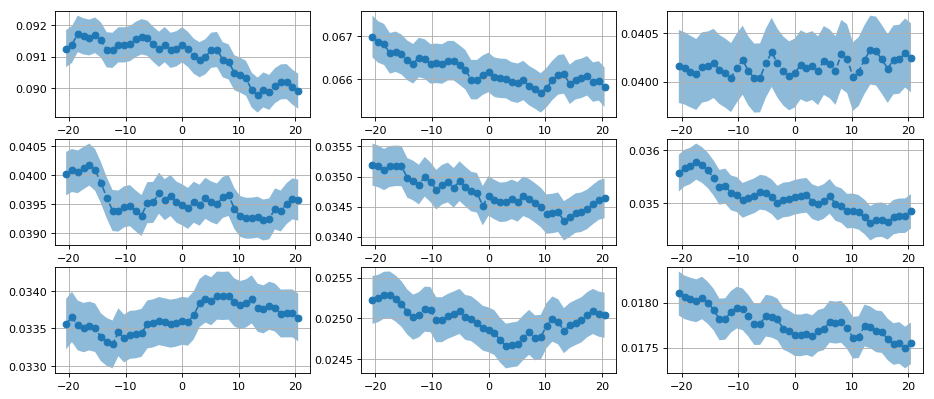

In [8]:
# plotting the rate per detector in each energy bin for the diffuse models
nr = 3
nc = 3
nplt = 1
fig = plt.figure(dpi=80, figsize=(14,6))
for j in range(9):
    ax = fig.add_subplot(nr,nc,nplt)
    nplt+=1
    try:
        rate_name = 'bkg_rate_' + str(j)
        rate = bkg_df[rate_name]
    except:
        rate_name = 'Background_bkg_rate_' + str(j)
        rate = bkg_df[rate_name]
    err0 = rate - bkg_df['err_'+rate_name]
    err1 = rate + bkg_df['err_'+rate_name]
    plt.fill_between(bkg_df['dt'], err0, err1, alpha=.5)
    plt.plot(bkg_df['dt'], rate, 'o--')
    plt.grid(True)

time with min counts, max counts
(32.768000000000065, 3.552713678800501e-14)
counts at min time, max time
(6760.0, 8209.0)
bkg mean, bkg std
(7023.0, 81.7038385963555)


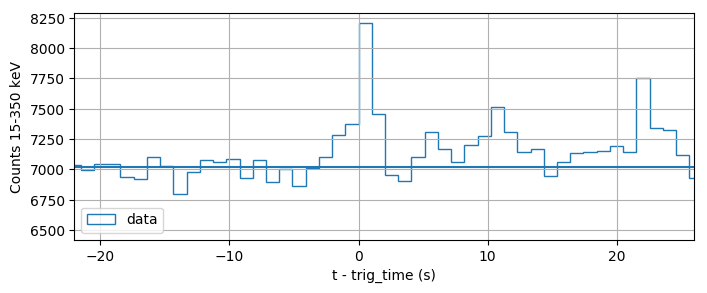

In [9]:
# plotting time hist of event data
tbins = np.arange(-40*1.024, 40*1.024, 0.064*4*4*1) # tbins with multiples of 64ms (64ms * 4 * 4 = 1.024s)
dt = tbins[1] - tbins[0]
tax = (tbins[1:] + tbins[:-1])/2.
ntbins = len(tax)
# choosing which tbins to estimate a flat bkg from for the plot
# bkg_bl = (np.abs(tax)>8.0)
bkg_bl = ((tax)<-10.0)&(tax>-40.0)

nc = 1
nr = 1
nplt = 1

fig = plt.figure(dpi=100, figsize=(8,3*nr))
ax = fig.add_subplot(nr,nc,nplt)
nplt += 1

h=plt.hist(ev_data0['TIME'] - trigger_time, bins=tbins,\
           histtype='step', label='data')[0]

bkg_mean = np.mean(h[bkg_bl])
bkg_std = np.std(h[bkg_bl])

print("time with min counts, max counts")
print (tbins[np.argmin(h)], tbins[np.argmax(h)])
print("counts at min time, max time")
print(np.min(h), np.max(h))
print("bkg mean, bkg std")
print(bkg_mean, bkg_std)

plt.axhline(bkg_mean)
plt.grid(True)
plt.xlim(-22, 26)
# plt.xlim(-4, 4.)
plt.ylim(np.around(.95*np.min(h[(h>0)]), decimals=-1),\
         np.round(1.01*np.max(h), decimals=-1))
plt.xlabel('t - trig_time (s)')
plt.ylabel('Counts 15-350 keV')
plt.legend(loc='lower left')

15.0 - 24.0 keV
time with min counts, max counts
(-5.119999999999969, 21.504000000000055)
counts at min time, max time
(1686.0, 1884.0)
bkg mean, bkg std
(1774.7586206896551, 28.503666034526997)

24.0 - 35.0 keV
time with min counts, max counts
(-14.335999999999977, 26.62400000000006)
counts at min time, max time
(1009.0, 1197.0)
bkg mean, bkg std
(1086.2413793103449, 26.90167944047718)

35.0 - 48.0 keV
time with min counts, max counts
(-5.119999999999969, 3.552713678800501e-14)
counts at min time, max time
(578.0, 746.0)
bkg mean, bkg std
(627.7586206896551, 24.485963850412542)

48.0 - 64.0 keV
time with min counts, max counts
(-40.96, 3.552713678800501e-14)
counts at min time, max time
(564.0, 774.0)
bkg mean, bkg std
(614.8620689655172, 25.893314458570494)

64.0 - 84.0 keV
time with min counts, max counts
(32.768000000000065, 3.552713678800501e-14)
counts at min time, max time
(482.0, 675.0)
bkg mean, bkg std
(534.5172413793103, 22.40938948783742)

84.0 - 120.0 keV
time with min cou

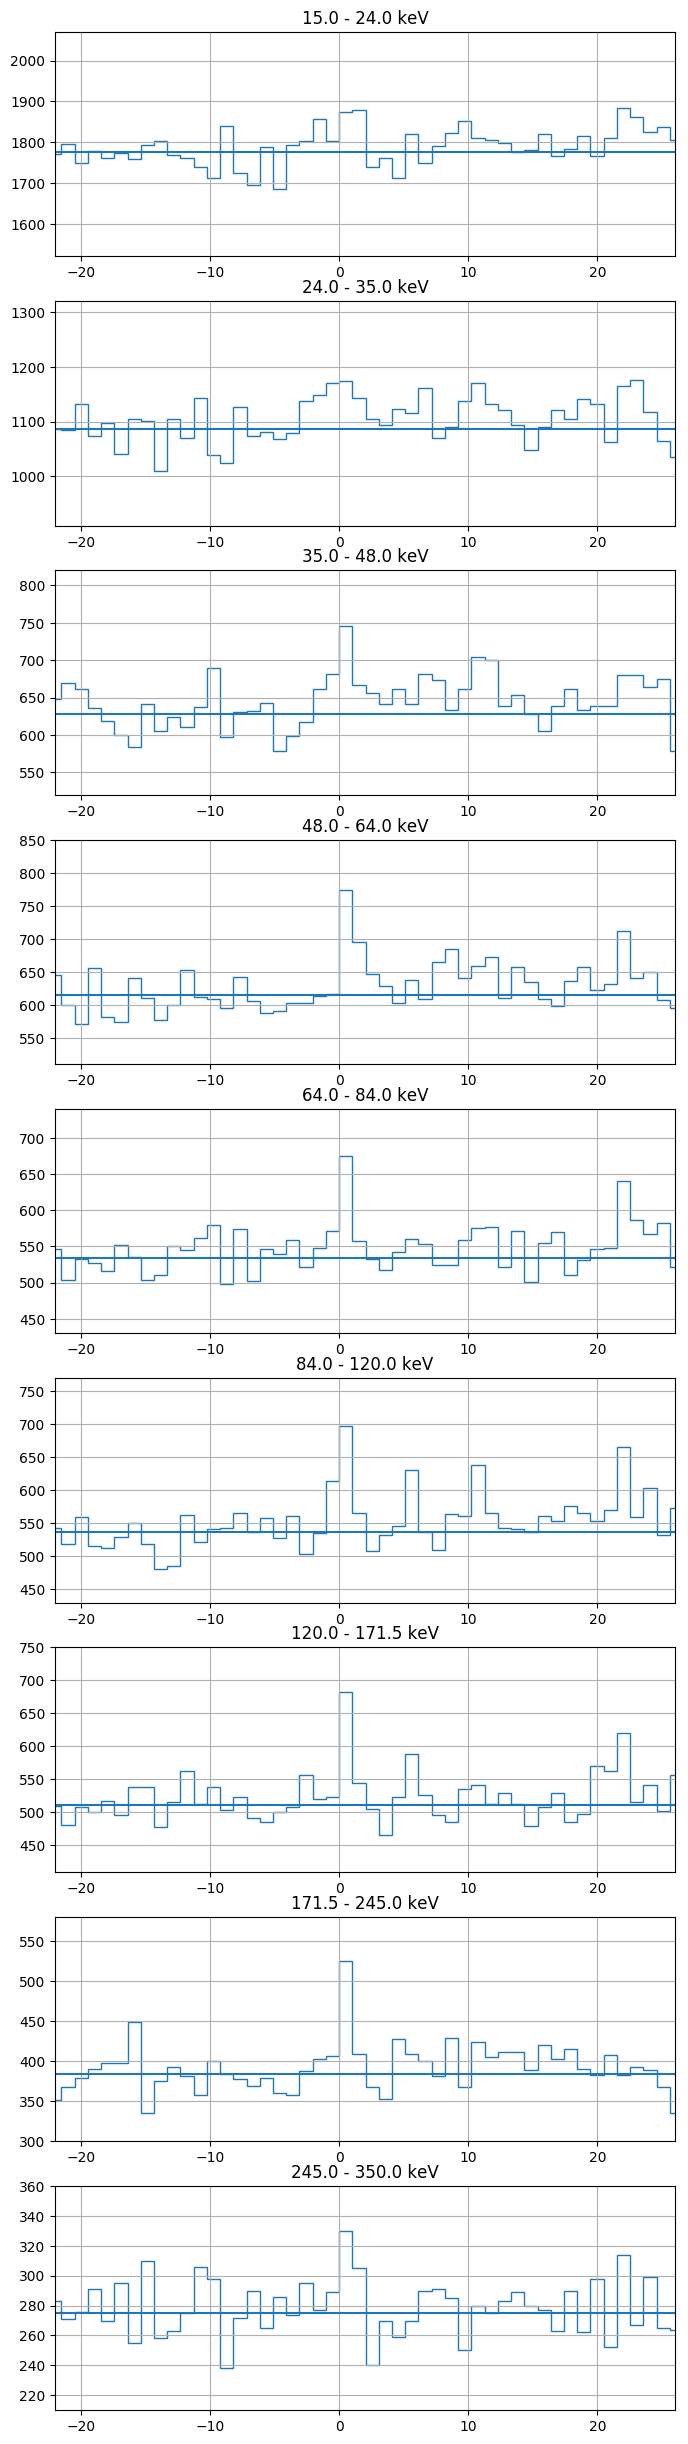

In [10]:
# plotting time hist with same bins as last cell but for each Ebin
nc = 1
nr = nebins
nplt = 1
fig = plt.figure(dpi=100, figsize=(8,3.5*nr))

for ei in xrange(nebins):
    ax = fig.add_subplot(nr,nc,nplt)
    nplt += 1
    ebl = (ev_data0['ENERGY']>=ebins0[ei])&\
            (ev_data0['ENERGY']<ebins1[ei])
    h=plt.hist(ev_data0[ebl]['TIME'] - trigger_time, bins=tbins,\
               histtype='step')[0]
    bkg_mean = np.mean(h[bkg_bl])
    bkg_std = np.std(h[bkg_bl])
    ttl = '%.1f - %.1f keV' %(ebins0[ei],ebins1[ei])
    print(ttl)
    print("time with min counts, max counts")
    print (tbins[np.argmin(h)], tbins[np.argmax(h)])
    print("counts at min time, max time")
    print(np.min(h), np.max(h))
    print("bkg mean, bkg std")
    print(bkg_mean, bkg_std)
    print
    plt.axhline(bkg_mean)
    plt.title(ttl)
    plt.grid(True)
#     plt.xlim(-2, 2)
    plt.xlim(-22, 26)
    plt.ylim(np.around(.9*np.min(h[(h>0)]), decimals=-1),\
             np.round(1.1*np.max(h), decimals=-1))

('QUATERNION: ', array([-0.03597053,  0.2345147 , -0.64420835,  0.72712074]))
Pointing RA, Dec
(273.5996900829163, -17.13930771538036)


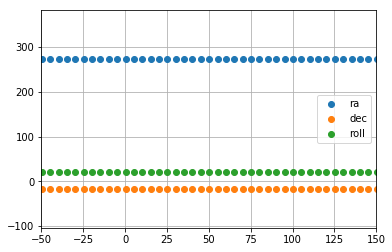

In [11]:
# getting attitude information at trigger time
att_ind = np.argmin(np.abs(attfile['TIME'] - trigger_time))
att_quat = attfile['QPARAM'][att_ind]
print("QUATERNION: ", att_quat)
pnt_ra, pnt_dec = attfile['POINTING'][att_ind,:2]
print("Pointing RA, Dec")
print(pnt_ra, pnt_dec)
plt.plot(attfile['TIME']-trigger_time, attfile['POINTING'], 'o')
plt.grid(True)
plt.xlim(-50,150)
plt.legend(['ra','dec','roll'])

In [47]:
# if you have some ra, dec of interest (like a gbm localization or something)
# here's how to do conversions into detector coordinates (theta, phi) and (imx, imy)
ra_interest, dec_interest = 233.117, -26.213
print("RA of interest, Dec of interest")
print(ra_interest, dec_interest)
theta_interest, phi_interest = convert_radec2thetaphi(ra_interest, dec_interest, att_quat)
print("theta, phi")
print theta_interest, phi_interest
# imx, imy only valid at theta < 90 deg
imx_interest, imy_interest = convert_radec2imxy(ra_interest, dec_interest, att_quat)
print("imx, imy")
print imx_interest, imy_interest

RA of interest, Dec of interest
(233.117, -26.213)
theta, phi
38.54132137017975 137.65241966813443
imx, imy
-0.5887551341212707 -0.5366203642198198


In [13]:
%%time
# getting split rate analysis results

# get the file names
res_rate_fnames = get_rate_res_fnames(work_dir)
print("%d split rate result files"%(len(res_rate_fnames)))
# read files and merge into one Pandas Dataframe
res_rate_tab = get_merged_csv_df(res_rate_fnames, work_dir, ignore_index=True)
print("Merged split rate results table has %d rows"%(len(res_rate_tab)))
res_rate_tab['dt'] = res_rate_tab['time'] - trigger_time

24 split rate result files
Merged split rate results table has 53244 rows
CPU times: user 282 ms, sys: 26.3 ms, total: 308 ms
Wall time: 315 ms


do_manage2.py:170: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat(dfs, ignore_index=ignore_index)


In [14]:
res_rate_tab.sort_values('TS', ascending=False).head(64)

,4U 1700-377_rt_sum,A,Epeak,GRO J1655-40_rt_sum,GX 339-4_rt_sum,Sco X-1_rt_sum,TS,bkg_nllh,dur,gamma,hp_ind,imx,imy,ndets,nllh,phi,solid_angle,theta,time,timeID,dt
24189,3308.140625,0.005131,1000.000000,3096.148438,1976.254395,3396.428711,18.524986,261.024004,2.048,0.236981,NaN,0.08,-0.56,7147,89.436460,NaN,7206.133604,NaN,6.460184e+08,-5122048,-0.512
33777,3463.363281,0.005100,1000.000000,3397.006836,1976.254395,3573.353271,18.497463,264.219452,2.048,0.240639,NaN,-0.16,-0.56,7314,93.141376,NaN,7397.469045,NaN,6.460184e+08,-5122048,-0.512
29017,3897.023438,0.004559,1000.000000,3526.900879,1976.254395,4468.304688,18.450624,253.554914,2.048,0.187357,NaN,0.32,-0.40,9925,83.342152,NaN,10084.993057,NaN,6.460184e+08,-5122048,-0.512
51797,3542.836670,0.004821,1000.000000,3238.922852,1971.113525,4008.572021,18.420209,257.861285,2.048,0.221658,NaN,0.44,-0.40,8567,88.209233,NaN,8726.558695,NaN,6.460184e+08,-5122048,-0.512
46765,2914.345215,0.005365,1000.000000,2866.721680,1936.077148,2952.979980,18.413330,262.882505,2.048,0.264898,NaN,-0.10,-0.64,6090,93.357147,NaN,6129.661822,NaN,6.460184e+08,-5122048,-0.512
20381,3276.141602,0.004996,1000.000000,3046.996094,1964.611084,3501.029297,18.410200,255.301063,2.048,0.250540,NaN,0.38,-0.48,7545,85.833324,NaN,7671.704471,NaN,6.460184e+08,-5122048,-0.512
49145,3683.522461,0.004740,1000.000000,3367.135742,1976.254272,3998.754883,18.405803,256.258841,2.048,0.169867,NaN,0.26,-0.48,8639,86.872050,NaN,8773.869983,NaN,6.460184e+08,-5122048,-0.512
21129,4073.167236,0.004355,1000.000000,3558.800049,1976.254395,4918.258301,18.351019,251.132652,2.048,0.134831,NaN,0.38,-0.32,10908,82.752700,NaN,11082.322131,NaN,6.460184e+08,-5122048,-0.512
48329,2534.849609,0.005568,1000.000000,2437.718750,1814.178589,2535.038818,18.343302,260.442375,2.048,0.300736,NaN,0.14,-0.64,5263,92.204018,NaN,5257.262112,NaN,6.460184e+08,-5122048,-0.512
52953,2739.820312,0.005432,1000.000000,2669.706787,1966.270020,2753.237061,18.331746,262.678926,2.048,0.271188,NaN,0.02,-0.64,5709,94.652475,NaN,5735.294086,NaN,6.460184e+08,-5122048,-0.512


In [16]:
%%time
# getting out of FoV analysis results

res_out_fnames = get_out_res_fnames(work_dir)
print("%d out of FoV result files"%(len(res_out_fnames)))

res_out_tab = get_merged_csv_df_wpos(res_out_fnames, attfile, direc=work_dir, ignore_index=True)
print("Merged out of FoV results table has %d rows"%(len(res_out_tab)))
res_out_tab['dt'] = res_out_tab['time'] - trigger_time

2509 out of FoV result files
Merged out of FoV results table has 341224 rows
CPU times: user 23.4 s, sys: 1.36 s, total: 24.7 s
Wall time: 26.8 s


In [15]:
%%time
# getting in FoV analysis results

res_peak_fnames = get_peak_res_fnames(work_dir)
print("%d in FoV peaks result files"%(len(res_peak_fnames)))
# read files and merge in single dataframe, also convert detector coords into RA, Dec
res_peak_tab = get_merged_csv_df_wpos(res_peak_fnames, attfile, direc=work_dir, ignore_index=True)
print("Merged in FoV peaks results table has %d rows"%(len(res_peak_tab)))
res_peak_tab['dt'] = res_peak_tab['time'] - trigger_time

1052 in FoV peaks result files
Merged in FoV peaks results table has 1282878 rows
CPU times: user 13.7 s, sys: 848 ms, total: 14.6 s
Wall time: 15.6 s


In [29]:
# getting the max TS for each square/time seed combo
idx = res_peak_tab.groupby(['squareID','timeID'])['TS'].transform(max) == res_peak_tab['TS']
res_peak_maxSq_tab = res_peak_tab[idx]
print(len(res_peak_maxSq_tab))

2664


In [30]:
# initing flux model to calculate flux/fluences
flux_params = {'A':1.0, 'gamma':0.5, 'Epeak':1e2}
flux_mod = Cutoff_Plaw_Flux(E0=100.0)

In [31]:
%%time
# calculating fluence for each row based on the best fit spectral parameters 
fluncs = np.zeros(len(res_peak_maxSq_tab))
flux_pars = {'A':1.0, 'Epeak':1e2, 'gamma':0.5}
i = 0
for ind, row in res_peak_maxSq_tab.iterrows():
    flux_pars['A'] = row['A']
    flux_pars['gamma'] = row['gamma']
    flux_pars['Epeak'] = row['Epeak']
    fluncs[i] = get_eflux_from_model(flux_mod, flux_pars, 1e1, 1e3)*row['dur'] # fluence from 10keV to 1MeV
    i+=1
#     res_peak_maxSq_tab.loc[ind]['fluence'] = get_eflux_from_model(flux_mod, flux_pars, 1e1, 1e3)*row['dur']
res_peak_maxSq_tab['fluence'] = fluncs

CPU times: user 3.3 s, sys: 5.11 ms, total: 3.31 s
Wall time: 3.31 s


/storage/work/j/jjd330/conda/my-envs/myenv/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [35]:
# max TS peak result
print np.max(res_peak_maxSq_tab['TS'])
idx = res_peak_maxSq_tab['TS'].idxmax()
row = res_peak_maxSq_tab.loc[idx]
max_TS_timeID = row['timeID']
row

18.88998837595465


Unnamed: 0    1.430000e+02
A             5.439460e-03
Epeak         9.189738e+02
TS            1.888999e+01
bkg_nllh      4.603944e+04
dur           2.048000e+00
gamma         2.000000e-01
imx          -5.890000e-01
imy          -5.350000e-01
nllh          4.586102e+04
phi           1.377505e+02
theta         3.850943e+01
time          6.460184e+08
timeID       -5.122048e+06
squareID      1.761000e+03
ra            2.331463e+02
dec          -2.614926e+01
dt           -5.119998e-01
fluence       2.006761e-06
Name: 16019, dtype: float64

In [32]:
res_peak_maxSq_tab.sort_values('TS', ascending=False).head(64)

,Unnamed: 0,A,Epeak,TS,bkg_nllh,dur,gamma,imx,imy,nllh,phi,theta,time,timeID,squareID,ra,dec,dt,fluence
16019,143,0.005439,918.973797,18.889988,46039.440350,2.048,2.000000e-01,-0.589,-0.535,45861.024519,137.750529,38.509432,6.460184e+08,-5122048,1761,233.146251,-26.149265,-0.512,0.000002
441214,88,0.003991,918.973797,18.166359,46039.440348,2.048,-1.000000e-01,0.285,-0.372,45874.432043,52.543226,25.108943,6.460184e+08,-5122048,2865,282.469719,-41.065866,-0.512,0.000002
405809,161,0.004440,918.973797,18.099210,46039.440348,2.048,-2.775558e-17,0.265,-0.483,45875.649640,61.248438,28.851294,6.460184e+08,-5122048,2812,278.561099,-45.698056,-0.512,0.000002
407681,89,0.004446,918.973797,18.095792,46039.440349,2.048,-2.775558e-17,0.265,-0.483,45875.711503,61.248438,28.851294,6.460184e+08,-5122048,2813,278.561099,-45.698056,-0.512,0.000002
11618,116,0.004758,918.973797,18.092233,46039.440350,2.048,-2.775558e-17,-0.603,-0.491,45875.775909,140.845382,37.869285,6.460184e+08,-5122048,1712,233.702487,-24.195588,-0.512,0.000002
5804,134,0.005309,918.973797,18.080242,46039.440350,2.048,2.000000e-01,-0.667,-0.559,45875.992777,140.034268,41.032075,6.460184e+08,-5122048,1661,230.254666,-24.851080,-0.512,0.000002
4994,296,0.005313,918.973797,18.078437,46039.440351,2.048,2.000000e-01,-0.667,-0.559,45876.025403,140.034268,41.032075,6.460184e+08,-5122048,1660,230.254666,-24.851080,-0.512,0.000002
293029,133,0.004331,918.973797,18.015078,46039.440349,2.048,-1.000000e-01,0.075,-0.493,45877.168832,81.349928,26.504159,6.460184e+08,-5122048,2562,265.791234,-42.798293,-0.512,0.000002
10670,140,0.005651,729.966834,17.972488,46039.440350,2.048,-2.775558e-17,-0.633,-0.537,45877.935185,139.690684,39.695902,6.460184e+08,-5122048,1711,231.737724,-25.013145,-0.512,0.000002
384568,142,0.004057,918.973797,17.972456,46039.440348,2.048,-1.000000e-01,0.231,-0.401,45877.935760,60.055483,24.833586,6.460184e+08,-5122048,2765,278.302542,-41.648896,-0.512,0.000002


In [39]:
# max TS out result
print np.max(res_out_tab['TS'])
idx = res_out_tab['TS'].idxmax()
row = res_out_tab.loc[idx]
max_TSout_timeID = row['timeID']
row

17.93049827144411


Unnamed: 0    2.600000e+01
A             2.254872e-02
Epeak         6.309573e+02
TS            1.793050e+01
bkg_nllh      4.603944e+04
dur           2.048000e+00
gamma         1.600000e+00
nllh          4.587869e+04
phi           1.553214e+02
theta         7.526322e+01
time          6.460184e+08
timeID       -5.122048e+06
hp_ind        1.611000e+03
ra            1.968750e+02
dec          -7.180756e+00
dt           -5.119998e-01
Name: 90738, dtype: float64

In [34]:
res_out_tab.sort_values('TS', ascending=False).head(64)

,Unnamed: 0,A,Epeak,TS,bkg_nllh,dur,gamma,nllh,phi,theta,time,timeID,hp_ind,ra,dec,dt
90738,26,0.022549,630.957344,17.930498,46039.440354,2.048,1.6,45878.688970,155.321410,75.263221,6.460184e+08,-5122048,1611,196.8750,-7.180756,-0.512
90745,33,0.022179,1584.893192,17.929094,46039.440354,2.048,1.8,45878.714140,155.321410,75.263221,6.460184e+08,-5122048,1611,196.8750,-7.180756,-0.512
90735,23,0.020974,1000.000000,17.929017,46039.440354,2.048,1.6,45878.715529,155.321410,75.263221,6.460184e+08,-5122048,1611,196.8750,-7.180756,-0.512
90741,29,0.020974,1000.000000,17.929017,46039.440354,2.048,1.6,45878.715529,155.321410,75.263221,6.460184e+08,-5122048,1611,196.8750,-7.180756,-0.512
90742,30,0.022679,1000.000000,17.922284,46039.440354,2.048,1.8,45878.836218,155.321410,75.263221,6.460184e+08,-5122048,1611,196.8750,-7.180756,-0.512
90744,32,0.019930,1584.893192,17.921898,46039.440354,2.048,1.6,45878.843140,155.321410,75.263221,6.460184e+08,-5122048,1611,196.8750,-7.180756,-0.512
90730,18,0.024943,398.107171,17.915766,46039.440354,2.048,1.6,45878.953011,155.321410,75.263221,6.460184e+08,-5122048,1611,196.8750,-7.180756,-0.512
90739,27,0.023441,630.957344,17.909630,46039.440354,2.048,1.8,45879.062929,155.321410,75.263221,6.460184e+08,-5122048,1611,196.8750,-7.180756,-0.512
90737,25,0.021301,630.957344,17.895092,46039.440354,2.048,1.4,45879.323197,155.321410,75.263221,6.460184e+08,-5122048,1611,196.8750,-7.180756,-0.512
214774,30,0.016178,398.107171,17.894867,46039.440354,2.048,2.4,45879.327226,112.677901,64.787443,6.460184e+08,-5122048,2701,202.5000,-48.141208,-0.512


In [40]:
# get best out of FoV result for each healpix pixel for a certrain time bin
bl = np.isclose(res_out_tab['timeID'],max_TSout_timeID)
idx = res_out_tab[bl].groupby(['hp_ind'])['TS'].transform(max) == res_out_tab[bl]['TS']
res_hpmax_tab = res_out_tab[bl][idx]

In [41]:
%%time
# get fluence for each row of res_hpmax_tab
fluncs = np.zeros(len(res_hpmax_tab))
flux_pars = {'A':1.0, 'Epeak':1e2, 'gamma':0.5}
# for i in range(len(res_peak_maxSq_tab)):
i = 0
for ind, row in res_hpmax_tab.iterrows():
    flux_pars['A'] = row['A']
    flux_pars['gamma'] = row['gamma']
    flux_pars['Epeak'] = row['Epeak']
    fluncs[i] = get_eflux_from_model(flux_mod, flux_pars, 1e1, 1e3)*row['dur']
    i+=1
res_hpmax_tab['fluence'] = fluncs

CPU times: user 3.27 s, sys: 1.42 ms, total: 3.27 s
Wall time: 3.27 s


In [38]:
res_hpmax_tab.sort_values('TS', ascending=False).head(64)

,Unnamed: 0,A,Epeak,TS,bkg_nllh,dur,gamma,nllh,phi,theta,time,timeID,hp_ind,ra,dec,dt,fluence
90738,26,0.022549,630.957344,17.930498,46039.440354,2.048,1.6,45878.688970,155.321410,75.263221,6.460184e+08,-5122048,1611,196.875000,-7.180756,-0.512,0.000003
214774,30,0.016178,398.107171,17.894867,46039.440354,2.048,2.4,45879.327226,112.677901,64.787443,6.460184e+08,-5122048,2701,202.500000,-48.141208,-0.512,0.000003
227418,26,0.015754,251.188643,17.866926,46039.440354,2.048,2.2,45879.826837,66.506182,64.258877,6.460184e+08,-5122048,2824,285.000000,-81.219822,-0.512,0.000003
93600,32,0.024452,1584.893192,17.840089,46039.440354,2.048,1.6,45880.305961,156.884201,78.620145,6.460184e+08,-5122048,1633,194.062500,-4.780192,-0.512,0.000004
234089,33,0.018177,630.957344,17.821293,46039.440354,2.048,1.8,45880.641119,37.350698,71.161062,6.460184e+08,-5122048,2881,355.500000,-60.434439,-0.512,0.000003
93999,23,0.022506,1000.000000,17.818541,46039.440354,2.048,1.6,45880.690145,160.059037,76.623800,6.460184e+08,-5122048,1636,196.875000,-2.388015,-0.512,0.000003
94005,29,0.022506,1000.000000,17.818541,46039.440354,2.048,1.6,45880.690145,160.059037,76.623800,6.460184e+08,-5122048,1636,196.875000,-2.388015,-0.512,0.000003
233953,33,0.018373,630.957344,17.808011,46039.440354,2.048,1.8,45880.877722,40.533213,70.874880,6.460184e+08,-5122048,2880,355.000000,-63.448284,-0.512,0.000003
90608,32,0.022516,1584.893192,17.806689,46039.440354,2.048,1.6,45880.901276,152.154065,77.287722,6.460184e+08,-5122048,1610,194.062500,-9.594068,-0.512,0.000004
201442,26,0.015306,251.188643,17.802646,46039.440354,2.048,2.2,45880.973252,76.323252,63.713755,6.460184e+08,-5122048,2566,236.250000,-78.284148,-0.512,0.000003


In [42]:
def get_dlogl_peak_out(res_peak_tab, res_out_tab):
    '''
    returns DeltaLLH_peak and DeltaLLH_out for the time bin with the max TS
    '''
    
    idx = res_peak_tab['TS'].idxmax()
    row = res_peak_tab.loc[idx]
    
    timeID = row['timeID']
    imdists = im_dist(row['imx'], row['imy'], res_peak_tab['imx'], res_peak_tab['imy'])
    bld = (imdists>0.012)&(res_peak_tab['timeID']==timeID)
    
    dlogl_peak = np.nanmin(res_peak_tab[bld]['nllh']) - row['nllh']
    
    blo = (res_out_tab['timeID']==timeID)
    
    dlogl_out = np.nanmin(res_out_tab[blo]['nllh']) - row['nllh']
    
    return dlogl_peak, dlogl_out

def get_dlogls_inout(res_tab, res_out_tab):
    '''
    returns DeltaLLH_peak, DeltaLLH_out, timeID for each time bin
    '''
    
    dlogls = []
    dlogls_in_out = []
    timeIDs = []
    for timeID, df in res_tab.groupby('timeID'):
        idx = df['TS'].idxmax()
        row = df.loc[idx]
        imdists = im_dist(row['imx'], row['imy'], df['imx'], df['imy'])
        bld = (imdists>0.012)
        try:
            dlogls.append(np.nanmin(df[bld]['nllh']) - row['nllh'])
        except Exception as E:
            print(E)
            dlogls.append(np.nan)
        blo = np.isclose(res_out_tab['timeID'],timeID,rtol=1e-9,atol=1e-3)
        dlogls_in_out.append(np.nanmin(res_out_tab[blo]['nllh']) - row['nllh'])
        timeIDs.append(timeID)
    return dlogls, dlogls_in_out, timeIDs

In [44]:
dlogl_peak, dlogl_out = get_dlogl_peak_out(res_peak_tab, res_out_tab)
print("\Delta LLH_peak = %.3f"%(dlogl_peak))
print("\Delta LLH_out = %.3f"%(dlogl_out))

\Delta LLH_peak = 13.408
\Delta LLH_out = 17.664


In [46]:
# %%time
dlogls_peak, dlogls_out, list_timeIDs = get_dlogls_inout(res_peak_tab, res_out_tab)
for i in range(len(list_timeIDs)):
    print "timeID = %d"%(list_timeIDs[i])
    print "\Delta LLH_peak = %.3f"%(dlogls_peak[i])
    print "\Delta LLH_out = %.3f"%(dlogls_out[i])
    print

timeID = -5122048
\Delta LLH_peak = 13.408
\Delta LLH_out = 17.664

timeID = -2561024
\Delta LLH_peak = 0.842
\Delta LLH_out = 7.147

timeID = 1024
\Delta LLH_peak = 0.449
\Delta LLH_out = 2.511

timeID = 2561024
\Delta LLH_peak = 0.341
\Delta LLH_out = 4.529

